<a href="https://colab.research.google.com/github/sanjabh11/fastai-v3/blob/master/Plants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating your own plants classifier


We intend to perform image segmentation on the plant phenotyping dataset. The dataset contains images(rgb coloured and masked labels) of 3 different classes of plants(1 and 2 : both consisting of top-view time-lapse images of Arabidopsis thaliana rosettes; and 3 : Tobacco plants).
We will use Fastai/Pytorch library to classify with minimum lavel of coding...

In [0]:
from fastai.vision import *

##Download images

The dataset can be downloaded from here-->http://www.plant-phenotyping.org/CVPPP2014-dataset
The technical report included with the dataset describes the data acquisition, plant material, and environmental conditions in detail.

In [0]:
!mkdir plants && wget http://download.fz-juelich.de/ibg-2/Plant_Phenotyping_Datasets.zip && unzip Plant_Phenotyping_Datasets.zip -d plants/

In [24]:
path = Path('/content/plants/Plant_Phenotyping_Datasets/Plant/')
path.ls()

[PosixPath('/content/plants/Plant_Phenotyping_Datasets/Plant/Ara2012'),
 PosixPath('/content/plants/Plant_Phenotyping_Datasets/Plant/Ara2013-RPi'),
 PosixPath('/content/plants/Plant_Phenotyping_Datasets/Plant/Ara2013-Canon'),
 PosixPath('/content/plants/Plant_Phenotyping_Datasets/Plant/Tobacco')]

In [29]:
# Create classes
classes = ['Ara2012', 'Ara2013-RPi','Ara2013-Canon', 'Tobacco']
classes

['Ara2012', 'Ara2013-RPi', 'Ara2013-Canon', 'Tobacco']

## View data

In [0]:
# Create a databunch object with 20% validation set
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [32]:
#View details of the dataset
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Ara2012', 'Ara2013-Canon', 'Ara2013-RPi', 'Tobacco'], 4, 1243, 310)

Good! Let's take a look at some of our pictures...

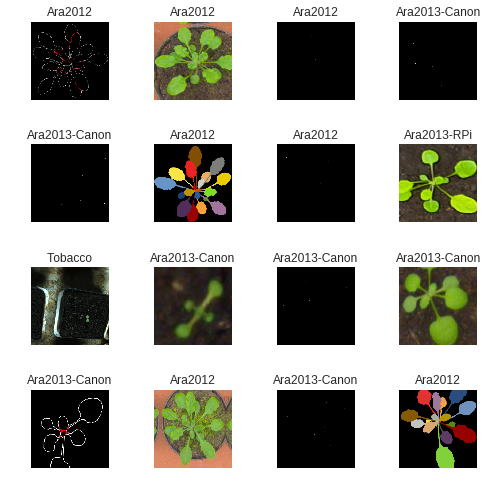

In [33]:
data.show_batch(rows=4, figsize=(7,7))

## Train model

In [34]:
learner = cnn_learner(data, models.resnet50, 
                      metrics=[error_rate, Recall(), Precision()], 
                      path='path')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:05, 20019344.16it/s]


In [0]:
#Let's make sure we have an appropriate loss function.
learner.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


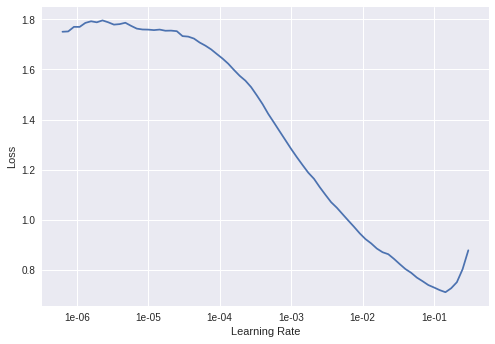

In [35]:
learner.lr_find()
learner.recorder.plot()

In [36]:
learner.fit_one_cycle(5, max_lr=slice(1e-3, 2e-01))

epoch,train_loss,valid_loss,error_rate,recall,precision,time
0,0.427221,2.039242,0.241935,0.852941,0.808776,11:32
1,1.037074,21.199612,0.209677,0.820969,0.852610,11:32
2,1.647223,0.864554,0.041935,0.966146,0.978188,11:24
3,1.523820,0.376894,0.045161,0.974265,0.968182,11:28
4,1.031929,0.039225,0.003226,0.997396,0.998175,11:33


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:179: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


##Result

Well, its great to see accuracy of 99.7% recall and 99,8% precison is just 5 epoch!! May be further unfreezing and fine tuning is not needed...


In [0]:
learner.save('stage-1')

In [41]:
learner.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1243 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ara2012,Ara2012,Ara2012,Ara2012,Ara2012
Path: /content/plants/Plant_Phenotyping_Datasets/Plant;

Valid: LabelList (310 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tobacco,Ara2012,Ara2012,Ara2012,Ara2013-Canon
Path: /content/plants/Plant_Phenotyping_Datasets/Plant;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

## Interpretation

In [0]:
learner.load('stage-1');

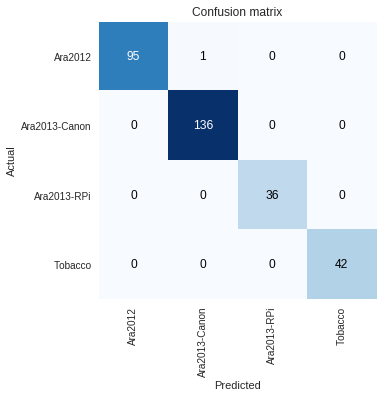

In [43]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
interp.plot_confusion_matrix()

Great to see only one wrong classification out of 310 images in the validation set...

In [44]:
interp.most_confused(1)

[]

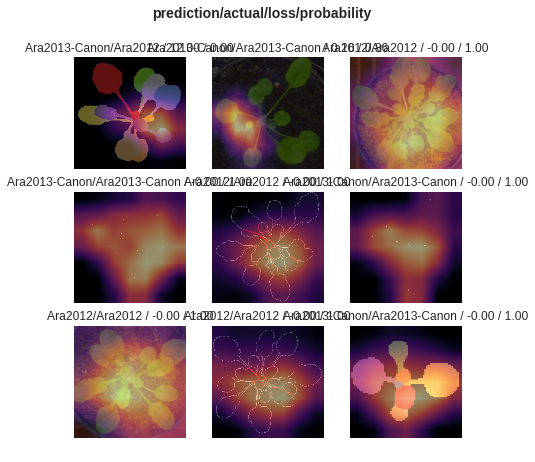

In [45]:
interp.plot_top_losses(9, figsize=(7,7))

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [0]:
#Save the internal information (classes, vocab in text, processors in tabular etc) need for inference in a file named ‘export.pkl’. 
data.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).